#  CNN1


Convolutional neuronal network with three conv layers.

First, we load the packages.



In [1]:
import pandas as pd
import numpy as np
from PIL import Image    
from sklearn.utils import shuffle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

from tqdm import tqdm_notebook

Then, we divide the data in train and validation (0.9 and 0.1). Also,we define the read function.

In [ ]:
data = pd.read_csv("newdata.csv")
data = shuffle(data)
m = len(data)

train = data[1:int(m*0.9)]
val = data[(int(m*0.9) + 1):]

m_train = len(train)
m_val = len(val)

path = "train/" + train.iloc[1][1]+ ".tif"
img = cv2.imread(path) 
h_s = np.shape(img)[0]
v_s = np.shape(img)[1]
n_c = np.shape(img)[2]
def readimage(n_batch, n, X):
    batch = []
    for i in range(n):
        path = "train/" + X.iloc[i+n*n_batch]['id']+ ".tif"
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        batch.append(np.moveaxis(img, -1,0))
        
    return torch.tensor(np.array(batch)).float()

Bath size: 29. <br>
Kernels_i: (m_conv_i,m_conv_i,c_conv_i). <br>
Stride of kernel: 1. <br>
Pool layer: Max. 

In [30]:
batchsize = 29
n_batch = int(m_train / batchsize)

n_batchval = int(m_val / batchsize)
batchsize = 29
n_batch = int(m_train / batchsize)

n_batchval = int(m_val / batchsize)

m_conv1 = 7
n_conv1 = 15
s_conv1 = 1

m_pool1 = 4
s_pool1 = 2

m_conv2 = 5
n_conv2 = 20
s_conv2 = 1

m_pool2 = 4
s_pool2 = 2

m_conv3 = 3
n_conv3 = 30

m_pool3 = 2
s_pool3 = 2


m_fullyconnected = 8

l_rate = 0.001
mom = 0.8


Model and train

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #(3,96,96)
        self.conv1 = nn.Conv2d(3, n_conv1, m_conv1, s_conv1)
        #size (15, 90, 90)
        self.pool1 = nn.MaxPool2d(m_pool1,s_pool1)
        #size(15, 44, 44)
        self.conv2 = nn.Conv2d(n_conv1, n_conv2, m_conv2, s_conv2)
        #size (20,40, 40 )
        self.pool2 = nn.MaxPool2d(m_pool2, s_pool2)
        #size (20, 18, 18)
        self.conv3 = nn.Conv2d(n_conv2, n_conv3, m_conv3)
        #size (30,16, 16 )
        self.pool3 = nn.MaxPool2d(m_pool3, s_pool3)
        #size (30, 8, 8)
        self.fc1 = nn.Linear(n_conv3 * m_fullyconnected * m_fullyconnected,1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0),n_conv3 * m_fullyconnected * m_fullyconnected)
        x = self.fc1(x)
        return torch.sigmoid(x)
    
def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(1)
    
net=Net()
optimizer = optim.SGD(net.parameters(), lr=l_rate, momentum=mom)
# create a loss function
criterion = nn.BCELoss()

train_loss = []
val_loss = []

for epoch in notebook.tqdm(range(100)):
    train = shuffle(train)
    batch_train_loss = 0
    for i in range(n_batch):
        data = readimage(i, batchsize,train)
        data = data/255
        data = torch.Tensor(data)
        target = torch.Tensor(train['label'][batchsize * i:batchsize * (i+1)].values)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out.view(batchsize,1), target.view(batchsize,1))
        loss.backward()
        optimizer.step()
        batch_train_loss += loss.item()
    train_loss.append(batch_train_loss / n_batch)
    batch_val_loss = 0
    for  k in range(n_batchval):
        data = readimage(k, batchsize, val)
        data = data/255
        target = torch.Tensor(val['label'][batchsize * k:batchsize * (k+1)].values)
        data, target = Variable(data), Variable(target)
        with torch.no_grad(): # 1) As do not want to update G 
            net_out = net(data) 
        batch_val_loss = batch_val_loss + (criterion(net_out.view(batchsize, 1), target.view(batchsize, 1)).item())
    val_loss.append(batch_val_loss / n_batchval)
    print(train_loss[epoch], val_loss[epoch], epoch)

Learning curve:

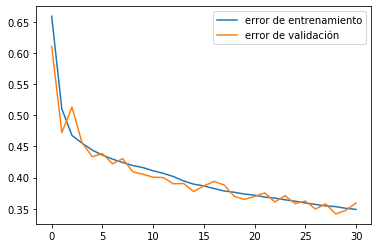

In [32]:

plt.plot(range(len(l)), l,label='error de entrenamiento')
plt.plot(range(len(l)), val_loss, label='error de validación')
plt.legend(loc="upper right")


ROC curve:
       
        

AUC: 0.930
AUC NO SKILL: 0.500


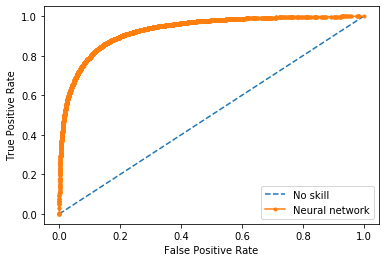

In [69]:
n_prob = [0 for _ in range(val_size)]
value = []
out = []
for  k in range(val_size):
        data = Readimageval(k,1)
        data = data/255
        target = val['label'].values[k]
        data =  Variable(data)
        with torch.no_grad(): # 1) As do not want to update G 
            net_out = net(data) 
        value.append(target)
        out.append(net_out.item())

fpr1, tpr1, thresholds = roc_curve(value, out, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(value, n_prob, pos_label = 1)
auc1 = roc_auc_score(value, out)
auc2 = roc_auc_score(value, n_prob)


print('AUC: %.3f' % auc1)
print('AUC NO SKILL: %.3f' % auc2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='No skill')
pyplot.plot(fpr1, tpr1, marker='.', label='Neural network')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

Example of kernels:

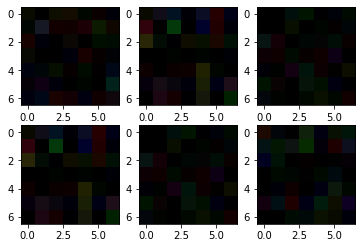

In [107]:
kernels = F.relu(net.conv1.weight.detach())
fig, axarr = plt.subplots(2,3)
for idx in range(2):
    for j in range(3):
        axarr[idx,j].imshow(kernels[idx+j].view(7,7,-1))